In [1]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

# Numerical precision

On a computer, there is necessarily a limited amount of space available for storing numbers. The most common arrangement for storing real numbers is the IEEE 754 standard for floating point numbers: https://en.wikipedia.org/wiki/IEEE_754

* **Single precision uses 4 bytes**, corresponding to approximately 7 decimal digits
* **Double precision uses 8 bytes**, corresponding to approximately 16 decimal digits

Floating point (often just called float) refers to the fact that decimal point is not in a fixed place, which means that the range of numbers that can be stored is far greater than 7 or 16 digits respectively.

Below, we will see some examples of cases where the finite precision gives rise to behaviour that is perhaps unexpected.

## Huge and Tiny

The largest number, and smallest positive (non-zero) number, that can be stored in floating point are sometimes called huge and tiny. These depend on the type of floating point number (single or double). Many (most?) languages have functions to find these values, but note that the 

In fortran, use the functions ``tiny(x)`` and ``huge(x)`` on a real of the desired type.

In python these can be found from ``numpy.finfo`` (short for float info), see code below.

In [2]:
# Single precision: 4 byte (32 bit) float
print('Single precision:')
print('tiny: ', np.finfo(dtype = np.float32).tiny)
print('huge: ', np.finfo(dtype = np.float32).max)
print()

# Double precision: 8 byte (64 bit) float
print('Double precision:')
print('tiny: ', np.finfo(dtype = np.float64).tiny)
print('huge: ', np.finfo(dtype = np.float64).max)

Single precision:
tiny:  1.1754944e-38
huge:  3.4028235e+38

Double precision:
tiny:  2.2250738585072014e-308
huge:  1.7976931348623157e+308


## Addition is not in general commutative on the computer

Mathematically, we have that $a + b + c = c + b + a$. However, this does not always hold on the computer, due to finite precision.

When you try to calculate for example $1 + 6\times10^{-17} + 6\times10^{-17}$, the result of the first addition is $1.00000000000000006$, which differs from 1 only in the 17th digit. So when you store the result of the calculation with only 16 digits, the difference is lost, and you get $1 + 6\times10^{-17} = 1$. Then the same thing happens in the next addition.

If instead you calculate $6\times10^{-17} + 6\times10^{-17} + 1$, then the result of the first addition is $1.2\times10^{-16}$. When you add that to 1, the result is $1.00000000000000012$, which differs from 1 in the 16th digit, and thus is stored as a number different from 1.

(Note that the numbers are in reality stored in binary format, and the mapping to decimal numbers isn't always obvious without working out the details. This is the reason the calculation below ends up with $1.0000000000000002$ instead of  $1.0000000000000001$, as you'd expect.)

In [3]:
# If we add two small numbers together, and then add 1,
# the result is different from 1
print('6e-17 + 6e-17 + 1 = ', 6e-17 + 6e-17 + 1)

# If we start with 1, and add first one, then a second small number,
# then the result is 1.
# The reason is that the first sum differs from 1 only in
# the 17th digit, which is not stored.
print('1 + 6e-17 + 6e-17 = ', 1 + 6e-17 + 6e-17)

6e-17 + 6e-17 + 1 =  1.0000000000000002
1 + 6e-17 + 6e-17 =  1.0


## Machine epsilon

The smallest number that you can add to 1, and have the result be different from 1, is called machine epsilon, or just epsilon. Many (most?) programming languages have functions to find this value for different types of numbers.

In fortran, use the function ``epsilon(x)`` on a real ``x``, of the type (double or single) you wish to know about.

In python this can be found from ``numpy.finfo`` (short for float info), see code below.

In [4]:
# Single precision: 4 byte (32 bit) float
print('Single precision:')
print('epsilon: ', np.finfo(dtype = np.float32).eps)
print()

# Double precision: 8 byte (64 bit) float
print('Double precision:')
print('epsilon: ', np.finfo(dtype = np.float64).eps)

Single precision:
epsilon:  1.1920929e-07

Double precision:
epsilon:  2.220446049250313e-16


## An example: Harmonic numbers

Harmonic numbers are given by

$$ H_n = \sum_{k=1}^n \frac{1}{k} $$

In [5]:
# Calculate the harmonic number Hn, by doing the
# sum from the largest number to the smallest
def forward(n, dtype = np.float32):
    # This bit creates a variable Hn, of the
    # desired precision (single or double)
    Hn = dtype(0)
    
    # Loop from largest to smallest
    for i in range(1, n+1):
        # This makes sure that the number we add is of the same
        # datatype (single or double) as Hn
        Hn += dtype(1/i)
    return Hn

# Calculate the harmonic number Hn, by doing the
# sum in reverse order from the smallest to the largest number
def backward(n, dtype = np.float32):
    # This bit creates a variable Hn, of the
    # desired precision (single or double)
    Hn = dtype(0)
    
    # Loop from smallest to largest, stepping backwards
    for i in range(n, 0, -1):
        # This makes sure that the number we add is of the same
        # datatype (single or double) as Hn
        Hn += dtype(1/i)
    return Hn

In [6]:
# Find the Nth harmonic number
N = 5000000

# Here we use single precision.
# Calculate Hn in both ways, and print answer with 7 decimals.
print('Single precision:')
print('Forward sum:  %.7f' % forward(N))
print('Backward sum: %.7f' % backward(N))
print()

# Here we use double precision.
# Calculate Hn in both ways, and print answer with 16 decimals.
print('Double precision:')
print('Forward sum:  %.16f' % forward(N, dtype = np.float64))
print('Backward sum: %.16f' % backward(N, dtype = np.float64))

Single precision:
Forward sum:  15.4036827
Backward sum: 16.0078545

Double precision:
Forward sum:  16.0021642352985936
Backward sum: 16.0021642353000502


## Another example: Series approximation of the exponential function

One definition of the exponential function, $\mathrm{e}^{x}$ is by the infinite series

$$ \mathrm{e}^x = \sum_{n=0}^\infty \frac{x^n}{n!}. $$

Note that while this a definition of $\mathrm{e}^{x}$, and therefore exact, we can use it as an approximation by truncating the sum at some finite value. We will see some example where this works well, and not so well.

In [7]:
# Implementing a function to calculate exp(x) as a series,
# including only the first n terms, using either single or double precision.

def exp(x, n = 10, dtype = np.float32):
    # This bit creates a variable called result, of the
    # desired precision (single or double)
    result = dtype(0)
    for i in range(n):
        result += dtype(x**i / np.math.factorial(i))
    return result

In [8]:
# Comparing to exponential function from numpy, np.exp
# Note the large difference in precision between positive and negative numbers
print('Single precision')
x = 15
print('exp(%.2f)' % x)
print('Series: ', '%.10f' % exp(x, n = 400))
print('Numpy:  ', '%.10f' % np.exp(x))
print()
print('exp(%.2f)' % -x)
print('Series: ', '%.10f' % exp(-x, n = 400))
print('Numpy:  ', '%.10f' % np.exp(-x))

Single precision
exp(15.00)
Series:  3269017.5000000000
Numpy:   3269017.3724721107

exp(-15.00)
Series:  -0.0179761108
Numpy:   0.0000003059


In [9]:
# Comparing to exponential function from numpy, np.exp
# Note the large difference in precision between positive and negative numbers
print('Double precision')
x = 15
print('exp(%.2f)' % x)
print('Series: ', '%.10f' % exp(x, n = 400, dtype = np.float64))
print('Numpy:  ', '%.10f' % np.exp(x))
print()
print('exp(%.2f)' % -x)
print('Series: ', '%.10f' % exp(-x, n = 400, dtype = np.float64))
print('Numpy:  ', '%.10f' % np.exp(-x))

Double precision
exp(15.00)
Series:  3269017.3724721107
Numpy:   3269017.3724721107

exp(-15.00)
Series:  0.0000003059
Numpy:   0.0000003059


Text(0.5, 1.0, 'Negative x')

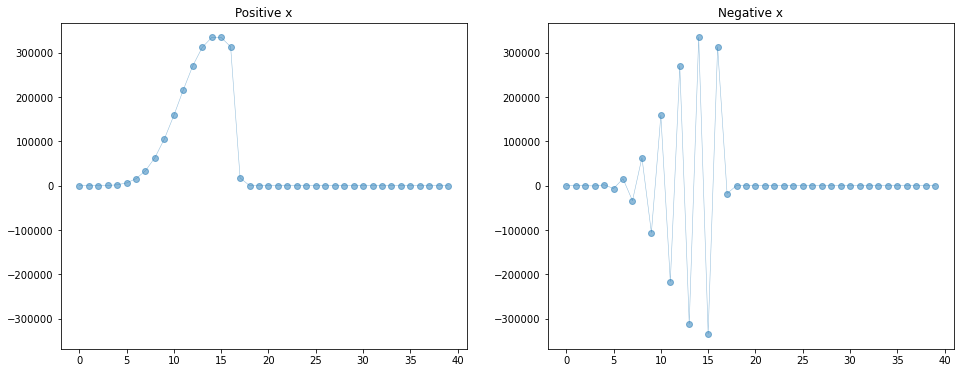

In [10]:
# Two plots to illustrate what's happening:

# Make a figure with two subplots, side by side.
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

# When x is positive, we calculate a large number (exp(x)), by
# adding large positive numbers, and the loss of precision is modest.
x =  15
N =  40

# Calculate the terms
ints  = np.arange(N)
terms = np.zeros(N)
for i in ints:
    terms[i] = x**i / np.math.factorial(i)

# Plot terms, set limits, add title and remove top and right axis
axes[0].plot(ints, terms, marker = 'o', linewidth = 0.5, alpha = 0.5)
axes[0].set_ylim((-1.1*max(terms), 1.1*max(terms)))
axes[0].set_title('Positive x')

# When x is negative, we calculate a small number (exp(x)), by
# adding alternating large positive and large negative numbers,
# which leads to a catastrophic loss of precision.
x =  -15

# Calculate the terms
ints  = np.arange(N)
terms = np.zeros(N)
for i in ints:
    terms[i] = x**i / np.math.factorial(i)
    
# Plot terms, set limits, add title and remove top and right axis
axes[1].plot(ints, terms, marker = 'o', linewidth = 0.5, alpha = 0.5)
axes[1].set_ylim(axes[0].get_ylim())
axes[1].set_title('Negative x')


## Examples: trigonometric functions

Because of finite precision, known values such as $\cos(\pi/2) = 0$ are not always exactly correct.

Identities such as

$$ \frac{1 - \cos(x)}{\sin(x)} = \frac{\sin(x)}{1 + \cos(x)}$$

are not always identical.

In [11]:
# Result should be 0, because cos(pi/2) = 0
x = np.float32(1e-9)
pi = np.float32(np.pi)

print(np.cos(pi/2) / x)

-43.71139123810498


In [12]:
# The two results should be the same
x = np.float32(1e-4)
print((1 - np.cos(x)) / np.sin(x))
print(np.sin(x) / (1 + np.cos(x)))

0.0
4.999999873689376e-05


In [13]:
# In double precision, they are closer
x = np.float64(1e-4)
print((1 - np.cos(x)) / np.sin(x))
print(np.sin(x) / (1 + np.cos(x)))

4.999999977945978e-05
5.000000004166667e-05


## Examples: Integers

In [14]:
# Pure python can use arbitrarily long integers
i = 98712307124870124098120398125124098

print(i)

98712307124870124098120398125124098


In [15]:
# Pure python can use arbitrarily long integers
i = np.math.factorial(400) + np.math.factorial(600)

print(i)

1265572316225430742541867824515082929767140386227466076818782885852814082314735123781780279561957107476520853259806022480324090378216476943079502557805427190628338764382608844812462648833262360837616408122117117943988584025781873291903788960371918674394336306213959378447392223185278254761977172388925247687118600017469793454911284566259618230828039061518469192444621555258652374008493280725905623896210468973152258756441223161801877435080152683956736744492820623131097361944035472371801286775301955613572137620795955886055993305285691415718465750290379378717494389685993060270414386001100968432824264787346029741012983909409595233147220912447756969919887447745606883046859960482720121892083851567598971975133086452219478584501590228124523499781178241865088319231081389473280988735520090976459206317766530277185746394333090841633328398789129638876157919642863930534386932720492382767479849884469848696425929464943885597810212886094734502447237726408972653034021481601349198140450594916824794234768539

In [16]:
# Numpy also has datatypes for 32bit and 64bit integers
# These cannot store very large numbers
np.int64(np.math.factorial(100))

OverflowError: Python int too large to convert to C long

In [17]:
# Find the largest possible int64
i = np.int64(np.iinfo(64).max)
print(i)

# Add 1, and print the result
print(i+1)

9223372036854775807
-9223372036854775808


<ipython-input-17-8015f48efc24>:6: RuntimeWarning: overflow encountered in long_scalars
  print(i+1)


In [18]:
# You can use the built-in function type() to
# inspect the type of variables.

i = 912840981409830495802397492837498752342

type(i)

int

In [19]:
k = np.int64(np.math.factorial(20))

type(k)

numpy.int64